In [1]:
from minisom import MiniSom

import pandas as pd
import numpy as np
import anndata as ad

import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib.lines import Line2D

# display matplotlib plots in notebook
%matplotlib inline
# display bokeh plot in notebook

In [2]:
input_dir = "/Users/apple/Desktop/KB/data"
# Load dataset

train_embeddings = np.load(input_dir+'/feat_train_test/biddy/bs30_sf0025/scBaseEncoderFeat_Z_bs30_tau0.5.npy')
print(train_embeddings.shape)

adata_train = ad.read_h5ad(input_dir+'/BiddyData/Biddy_train.h5ad')

# adata_train.obs['Cell type annotation'] = adata_train.obs["cell_type"]
# adata_test.obs['Cell type annotation'] = adata_test.obs["cell_type"]
train_labels = adata_train.obs["clone_id"].to_numpy()
print(train_labels.shape)


(9220, 64)
(9220,)


In [3]:
# Create a boolean mask based on the condition in adata_train
mask = (adata_train.obs["reprogramming_day"] == "12")
# Subset adata_train based on the mask
adata_subset = adata_train[mask]

# Subset train_embeddings based on the same mask
train_embeddings_subset = train_embeddings[mask.to_numpy()]

# Optionally, subset the labels if needed
train_labels_subset = adata_subset.obs['clone_id'].to_numpy()


In [5]:
som = MiniSom(15, 15,train_embeddings_subset.shape[1] , sigma=1.5, learning_rate=.7, activation_distance='euclidean',
              topology='hexagonal', neighborhood_function='gaussian', random_seed=10)

som.train(train_embeddings_subset, 10000000, verbose=True)

 [ 10000000 / 10000000 ] 100% - 0:00:00 left 
 quantization error: 0.8665565943288849


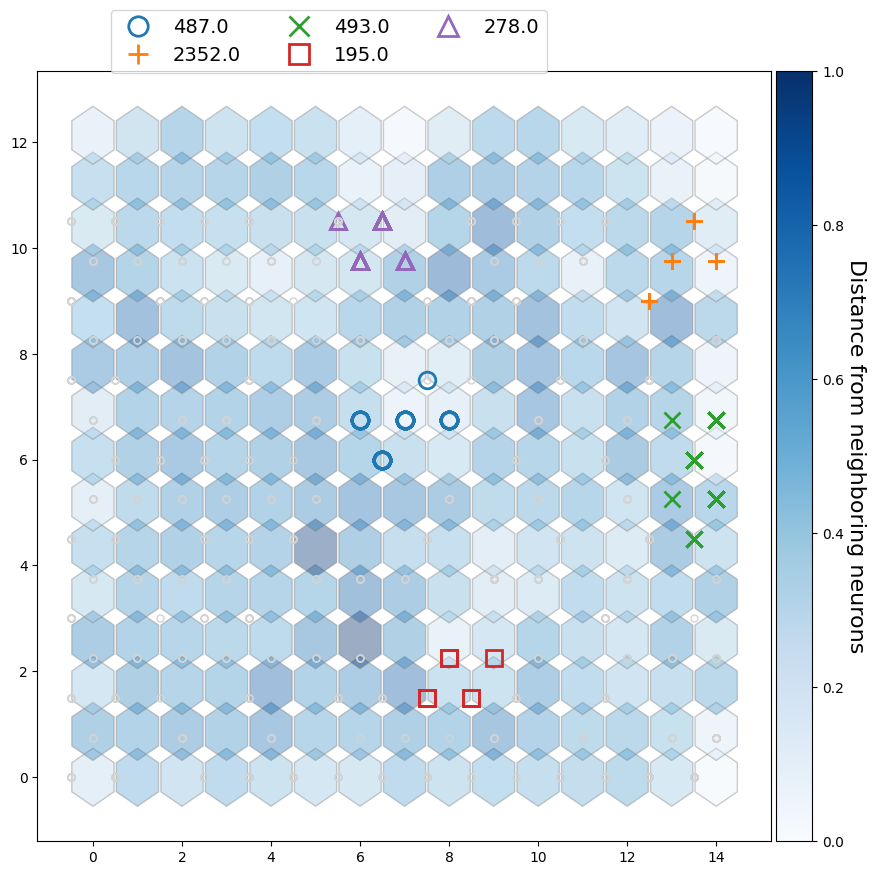

In [6]:
# Get the weights of the SOM after training
weights = som.get_weights()

# Calculate the U-matrix for visualization
umatrix = som.distance_map()

# Create a figure for the hexagonal grid visualization
fig, ax = plt.subplots(figsize=(10, 10))

# Create a hexagonal grid for the SOM
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        hex = RegularPolygon((i, j * np.sqrt(3) / 2), numVertices=6, 
                             radius=.95 / np.sqrt(3), 
                             facecolor=cm.Blues(umatrix[i, j]), 
                             alpha=.4, edgecolor='gray')
        ax.add_patch(hex)

# Define markers and colors for each unique label
markers = ['o', '+', 'x', 's', '^']
colors = ['C0', 'C1', 'C2', 'C3', 'C4']

# Find the top 5 unique labels in the dataset
unique_labels, counts = np.unique(train_labels_subset, return_counts=True)
top_5_labels = unique_labels[np.argsort(-counts)[:5]]

# Plot data points on the SOM grid
for cnt, x in enumerate(train_embeddings_subset):
    w = som.winner(x)  # Find the winning neuron
    wx, wy = som.convert_map_to_euclidean(w) 
    wy = wy * np.sqrt(3) / 2

    label = train_labels_subset[cnt]
    if label in top_5_labels:
        # Assign marker and color based on the label
        marker_index = np.where(top_5_labels == label)[0][0]
        plt.plot(wx, wy, markers[marker_index], 
                 markerfacecolor='None', markeredgecolor=colors[marker_index], 
                 markersize=12, markeredgewidth=2)
    else:
        # Plot all other points in light gray
        plt.plot(wx, wy, 'o', markerfacecolor='None', markeredgecolor='lightgray', 
                 markersize=5, markeredgewidth=1)

# Add colorbar for U-matrix
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
cb1 = colorbar.ColorbarBase(ax_cb, cmap=cm.Blues, 
                            orientation='vertical', alpha=.4)
cb1.ax.get_yaxis().labelpad = 16
cb1.ax.set_ylabel('Distance from neighboring neurons', 
                  rotation=270, fontsize=16)
plt.gcf().add_axes(ax_cb)

# Create a legend for the top 5 labels
legend_elements = [Line2D([0], [0], marker=markers[i], color=colors[i], 
                          label=top_5_labels[i], 
                          markerfacecolor='w', markersize=14, linestyle='None', 
                          markeredgewidth=2) for i in range(5)]
ax.legend(handles=legend_elements, bbox_to_anchor=(0.1, 1.08), loc='upper left', 
          borderaxespad=0., ncol=3, fontsize=14)

plt.show()
